In [ ]:
"""
Note: Main functions for testing provided at the bottom of the notebook
"""

# Imports and constants

In [19]:
import os
import pathlib
import numpy as np
from matplotlib import pyplot as plt
import librosa
import librosa.display as display
from scipy.ndimage import maximum_filter as maxFilt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
import random
import itertools


SAMPLE_RATE = 22050


# Utility functions

In [212]:
# get spectrogram

def get_spectr(path, sr=22050, win_len=1024, hop_len=256, 
               window='hann', spec_type='stft'):
    """
    Load an audio file and output is spectrogram.  
    """
    
    # stft spectrogram
    y, sr = librosa.load(os.path.join(path), sr)
    
    if spec_type == 'stft':
        spectr = np.abs(librosa.stft(y, n_fft=win_len, window=window, 
                                     win_length=win_len, 
                                     hop_length=hop_len))
    
    if spec_type == 'mel':
        spectr = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=win_len, 
                                                hop_length=hop_len, 
                                                win_length=win_len, 
                                                window=window)
    
    return spectr


In [213]:
# plot spectrogram, constellation map, or both superimposed

def graph(spectr=None, c_map=None, h_map=None, 
                         hop_length=512, h_map_hop=2):
    """
    Utility function for visualising spectrograms, 
    constellation maps and hash maps
    """
    
    # plot
    plt.figure(figsize=(10, 5))
    
    # spectrogram
    if spectr is not None:
        display.specshow(librosa.amplitude_to_db(spectr, ref=np.max), 
                         y_axis='linear', x_axis='time',cmap='YlGn',
                         sr=SAMPLE_RATE)
    
    # constellation map
    if c_map is not None:
        # re-scale values
        X = c_map.nonzero()[1] * hop_length / SAMPLE_RATE
        Y = c_map.nonzero()[0] * (SAMPLE_RATE / 2) / c_map.shape[0]
        
        # plot
        plt.scatter(X, Y, c='k', s=25, marker="o")
        
    if h_map is not None:
        # if only h_map
        if any((spectr is None, c_map is None)):
            Y, X = np.argwhere(h_map == 1).T
            plt.scatter(X, Y, c='b', s=20, marker = 's', alpha=0.8)
            plt.xlabel('time bins')
            plt.ylabel('frequency bins')
            
        
        else:
            # re-scale values
            X = (h_map.nonzero()[1] + 0.5) * hop_length * h_map_hop / SAMPLE_RATE
            Y = (h_map.nonzero()[0] + 0.5) * (SAMPLE_RATE / 2) / h_map.shape[0]
            plt.scatter(X, Y, c='r', s=30, marker = 's', alpha=0.5)  


# Audio Identification functions

## Constellation map

In [214]:
# find constellation map

def constellation_map(spectr, hop_length=256, freq_win=32, 
                      time_win=8, peak_thresh=0.4):
    """
    Returns a constellation map for a spectrogram
    
    freq_win, time_win define size of 2D maximum filter window
    
    Note: hop_length is the spectrogram hop length.  
    """
    
    # max filter
    filt_spectr = maxFilt(spectr, size=(freq_win, time_win), 
                          mode='constant')
    
    # find local peaks
    peaks = np.where(spectr == filt_spectr, spectr, 0)
    
    # set threshold for peaks and make output binary
    peaks = np.where(peaks > peak_thresh, 1, 0)
    
    return peaks


## Create hashes

In [215]:
# quantise constellation map into hash map

def hash_map(c_map, time_hop=1, freq_bins=32):
    """
    Get a hash map from a constellation map.  
    
    Parameters:
        c_map: Constellation map
        time_hop: number of time points per hash map bin
        freq_bins: total number of hash map frequency bins
    """
    # calculate window height
    freq_hop = c_map.shape[0] // freq_bins
    
    # number of horizontal hops
    time_bins = c_map.shape[1] // time_hop

    # initialise hash map
    hashmap = np.zeros((freq_bins, time_bins))

    # pass window over constellation map
    for i in range(freq_bins):
        for j in range(time_bins):
            ind = [i * freq_hop, (i + 1) * freq_hop, 
                   j * time_hop, (j + 1) * time_hop]
            if np.any(c_map[ind[0]: ind[1], ind[2]: ind[3]]):
                hashmap[i, j] = 1
            else:
                hashmap[i, j] = 0
            
    return hashmap


In [216]:
# create inverted list from hash map

def inverted_list(h_map):
    """
    Get an inverted list from a hash map
    """
    inv_list = {}
    for row in range(h_map.shape[0]):
        positions = np.nonzero(h_map[row, :])[0]
        if positions.size > 0:
            inv_list[row] = positions
            
    return inv_list


## Indicator function

In [7]:
# indicator function for a given time stamp

def matching(query_list, target_list):
    """
    Compare query and target inverted lists to get a matching function
    This is a set of {key: value} pairs corresponding with
         {time_position (int): score (int)}
    Only time positions with non-zero scores are included
    """
    # initialise dictionary for matching function
    matches = {}
    # loop through frequency bins in query inverted list
    for h, times in query_list.items():
        # check if the frequency bin key is in the target
        if h in target_list.keys():
            # loop through the times in the query
            for n in times:
                # find the values in the indicator function
                L = np.subtract(target_list[h], n)
                # add each value to the 'matches' dictionary
                for i in L:
                    try:
                        matches[i] += 1
                    except KeyError:
                        matches[i] = 1                
    return matches


In [8]:
# matching function for audio sample

def match_weight(matching):
    """
    Returns ths maximum score over all time positions for a 
        matching function
    """
    if len(matching) == 0:
        weight = 0
    else:
        weight = max(list(matching.values()))
    
    return weight


# Testing Functions

In [9]:
# Get inverted list from file

def get_inverted_list(path, spectr_kwargs={}, const_kwargs={}, hash_kwargs={}):
    """
    Puts the functions above into a sequence.  
    Parameters: 
        path: to an audio file
        keyword arguments for each of the functions
        
    Returns:
        Inverted list for the audio sample
    """
    # get spectrogram
    out = get_spectr(path, **spectr_kwargs)
    # get contellation map
    out = constellation_map(out, **const_kwargs)
    # get hash_map
    out = hash_map(out, **hash_kwargs)
    # get inverted_list
    out = inverted_list(out)
    
    return out
    

In [10]:
# create datatbase folder (not used)

def create_database_folder(name):
    """
    Utility function to create a fingerprints directory
    """
    base_path = './trial_databases/'
    os.mkdir(os.path.join(base_path, name))
    

In [82]:
# create fingerprint database evaluate and test function 

def fingerprintBuilderTest(database_path, 
                           fingerprints_path, 
                           max_files=None,
                           spectr_kwargs={}, 
                           const_kwargs={}, 
                           hash_kwargs={}):
    """
    Used to build fingerprint databases for parameter tuning, evaluation
    and testing
    """
    file_list = os.listdir(database_path)
    if max_files:
        file_list = file_list[:max_files]
    total_files = len(file_list)
    
    # loop through files
    for i, audiofile in enumerate(file_list):
        
        print(f"{i} files created out of {total_files} ...", end='\r')
        
        audiofilepath = os.path.join(database_path, audiofile)
        
        # get inverted list
        out = get_inverted_list(audiofilepath, spectr_kwargs, const_kwargs, hash_kwargs)
        
        # get filename in correct format        
        name = os.path.splitext(os.path.split(audiofile)[1])[0]        
        name = name + '.pkl'        
        name = os.path.join(fingerprints_path, name)
        
        # save list
        with open(name, 'wb') as f:
            pickle.dump(out, f)
        
    print('')
            

In [199]:
# get list of matching weights

def best_matches_list(query_inv_list, 
                      fingerprints_path, 
                      num_outputs=3, 
                      query_name=None):
    """
    Parameters:
        query_inv_list (dict): inverted list of 1 query item
        fingerprints_path (str): path to the fingerprints database
        num_outputs: how many 'best matches' to be returned [default: 3]
        query_name: include name of query file if list of all matching scores and 
            ground truth labels are requred for evaluation metrics
    Returns:
        best_matches: tuple of (matching weight, root of file name)
        scores: list of matching score for each of the database items
        labels: binary list of whether or not the database item is a true match for the query
    """
    
    # initialize dictionary for storing matching weights
    best_matches = []
    scores = []
    labels = []
    
    database = os.listdir(fingerprints_path)
    database_length = len(database)

    # loop through fingerprints database
    for idx, database_file in enumerate(database):
        
        filename = os.path.join(fingerprints_path, database_file)
        # load dict
        with open(filename, 'rb') as f:
            fingerprint = pickle.load(f)

        # get matching weight
        matching_function = matching(query_inv_list, fingerprint)
        weight = match_weight(matching_function)
        
        database_start = database_file[:-4]
        
        if query_name is not None:
            scores.append(weight)
            label = 1 if query_name.startswith(database_start) else 0
            labels.append(label)

        # check whether to add to best outcomes
        if not num_outputs or len(best_matches) < num_outputs:
            best_matches.append((weight, database_start))
        else:
            smallest = min(best_matches)
            if weight > smallest[0]:
                best_matches.remove(smallest)
                best_matches.append((weight, database_start))
                
    return best_matches, scores, labels


In [13]:
# audio identification function

def audioIdentificationTest(queryset_path, 
                            fingerprints_path, 
                            output_path, 
                            max_files=10, 
                            spectr_kwargs={}, 
                            const_kwargs={}, 
                            hash_kwargs={}):
    """
    Create a .txt file with three best matches for each query
    """
    # max files counter
    counter = 0
    
    # text file name
    output_name = 'output.txt'
    output_name = os.path.join(output_path, output_name)
    
    # open output file
    with open(output_name, 'w') as txt_file:
    
        # loop through query items    
        for query_file in os.listdir(queryset_path):
            counter += 1
            
            # get full path
            queryfile = os.path.join(queryset_path, query_file)

            # get inverted list
            out = get_inverted_list(queryfile, spectr_kwargs, const_kwargs, hash_kwargs)

            # get list of best matches
            query_matches, _, _ = best_matches_list(out, fingerprints_path, num_outputs=3, 
                                                   query_name=None)
            
            # get list of file names
            output_files = []
            for weight, name in sorted(query_matches):
                output_files.append(name)

            # write to file
            txt_file.write(f"{query_file}\t{output_files[2]}\t" \
                           f"{output_files[1]}\t{output_files[0]}\n")

            # if max_file condition given
            if max_files and counter >= max_files:
                break        


In [55]:
# split query set into evaluation and test

def create_eval_test_split(query_path, max_files=150, test_proportion=0.4, seed=1):
    """
    Utility function for randomly splitting query files into evaluation and test sets
    """
    file_list = os.listdir(query_path)
    if max_files:
        file_list = file_list[:max_files]
    
    evaluate, test = train_test_split(file_list, test_size=(test_proportion), 
                                      random_state=seed)
    
    return evaluate, test


In [205]:
# Evaluation function

def evaluate(queryset_path, 
             fingerprints_path, 
             query_file_list, 
             num_outputs=3, 
             roc_auc=False,
             map_score=False,
             spectr_kwargs={}, 
             const_kwargs={}, 
             hash_kwargs={}, 
             update_rate=20):
    """
    Return evaluation metrics for audio identification performance
    Returns:
        Mean Accuracy Score - Average hit rate of correct database item in the top n matches
            Note: set n with num_outputs parameter
        Mean ROC_AUC score
        Mean Average Precision score
    """
    map_score = 0
    mean_roc_auc_score = 0
    mean_accuracy_score = 0
    
    num_files = 0
    query_length = len(query_file_list)
    
    # loop through query items    
    for idx, query_file in enumerate(query_file_list):
        
        num_files += 1
        
        print(f"evaluating for file {idx} out of {query_length} ", end='\r')
        
        query_file_path = os.path.join(queryset_path, query_file)

        out = get_inverted_list(query_file_path, spectr_kwargs, const_kwargs, hash_kwargs)

        name = os.path.splitext(os.path.split(query_file)[1])[0]

        best_matches, scores, labels = best_matches_list(out, 
                                                         fingerprints_path, 
                                                         num_outputs=num_outputs, 
                                                         query_name=name)

        print(f"{query_file}: {best_matches[0][1]}, {best_matches[1][1]}, {best_matches[2][1]}")
        
        # AP score
        if map_score:
            map_score += average_precision_score(labels, scores)

        # get ROC-AUC score
        if roc_auc:
            mean_roc_auc_score += roc_auc_score(labels, scores)

        # calculate accuracy for best matches
        accuracy_score = 0
        for weight, name in best_matches:
            # check if the match was true
            if query_file.startswith(name):
                accuracy_score += 1
        mean_accuracy_score += accuracy_score

    print('')

    map_score = map_score / num_files if map_score else None
    mean_roc_auc_score = mean_roc_auc_score / num_files if roc_auc else None
    mean_accuracy_score = mean_accuracy_score / num_files
    
    return mean_accuracy_score, mean_roc_auc_score, map_score


In [171]:
# parameter random searcher

class ParameterRandomSearcher():
    """
    Provides random parameter searching.  
    Initialize with lists of parameters to search (note: some are integer ranges and 
        some are lists - see __init__ for details).
    Call get_scores() to test a random combination of parameters.  Results will be saved to file 
        and stored in self.search_params (dict).
    Best scores and corresponding keys for self.search_params stored in self.best_scores.
    Call self.test(key) to test performance with a given set of parameters on the separate test
        set.  The 'key' parameter refers to the key in self.search_params.  
    """
    def __init__(self, 
                 name,
                 query_file_number=None,
                 database_file_number=None,
                 testset_proportion=0.5, 
                 seed=1,
                 spectr_type=['stft', 'mel'], 
                 win_len = [512, 1024], 
                 hop_len = [512],
                 freq_win=[8, 24], 
                 time_win=[4, 20], 
                 peak_thresh=[0.3, 1, 3, 10], 
                 time_hop=[1, 6], 
                 freq_bins=[24, 32, 40], 
                 query_peak_thresh_multiplier=[0.6, 0.8, 1, 1.2, 1.4], 
                 num_track_best=10, 
                 roc_auc=True, 
                 map_score=True):
        
        # set random seed
        random.seed(seed)
        
        # directory paths
        self.query_path = './query_recordings'
        self.database_path = './database_recordings'
        self.save_path = './searcher_saves'
        self.name = name
        
        self.query_file_number = query_file_number
        self.database_file_number = database_file_number
        
        self.roc_auc = roc_auc
        self.map_score = map_score
        
        # parameter ranges
        self.spectr_type =spectr_type
        self.win_len = win_len
        self.hop_len = hop_len
        self.freq_win = [i for i in range(*freq_win)]
        self.time_win = [i for i in range(*time_win)]
        self.peak_thresh = peak_thresh
        self.time_hop = [i for i in range(*time_hop)]
        self.freq_bins = freq_bins
        self.query_peak_thresh_multiplier = query_peak_thresh_multiplier

        # directory to store fingerprint databases
        self.fingerprints_root = './trial_databases'
        
        self.next_index = itertools.count()
        
        # best MAP scores and corresponding index
        self.best_scores = {}
        self.num_track_best = num_track_best
        
        # dictionary of database number, parameter combination and scores
        self.search_params = {}
        
        # split query dataset into evaluation and test
        self.evaluate_set, self.test_set = create_eval_test_split(self.query_path, 
                                                                  max_files=self.query_file_number,
                                                                  test_proportion=testset_proportion, 
                                                                  seed=1)

        
    @property
    def num_searches(self):
        return len(self.search_params)
    
    
    def get_parameter_values(self):

        random.shuffle(self.spectr_type)
        random.shuffle(self.win_len)
        random.shuffle(self.hop_len)
        random.shuffle(self.freq_win)
        random.shuffle(self.time_win)
        random.shuffle(self.peak_thresh)
        random.shuffle(self.time_hop)
        random.shuffle(self.freq_bins)
        random.shuffle(self.query_peak_thresh_multiplier)
        
        
        params = [self.spectr_type[0], 
                  self.win_len[0], 
                  self.hop_len[0], 
                  self.freq_win[0], 
                  self.time_win[0], 
                  self.peak_thresh[0], 
                  self.time_hop[0], 
                  self.freq_bins[0], 
                  self.query_peak_thresh_multiplier[0]]
          
        return params
            
        
    def get_scores(self):

        # get parameter combination index
        index = next(self.next_index)

        # get parameters
        param_values = self.get_parameter_values()

        spectr_kwargs = {'spec_type': param_values[0], 
                         'win_len': param_values[1], 
                         'hop_len': param_values[2]}

        const_kwargs = {'hop_length': param_values[2], 
                        'freq_win': param_values[3], 
                        'time_win': param_values[4], 
                        'peak_thresh': param_values[5]}

        hash_kwargs = {'time_hop': param_values[6], 
                       'freq_bins': param_values[7]}

        # make a directory for the fingerprints database
        fingerprints_dir = self.name + str(index)
        os.mkdir(os.path.join(self.fingerprints_root, fingerprints_dir))
        full_fingerprints_dir = os.path.join(self.fingerprints_root, fingerprints_dir)
        
        print(f"Spectrogram: {spectr_kwargs}\nConstellation map: {const_kwargs}\n"
              f"Hash map: {hash_kwargs}\nQuery threshold multiplier: {param_values[8]}")
        print(f"Creating database {fingerprints_dir} ...")

        # build database
        fingerprintBuilderTest(self.database_path, 
                               full_fingerprints_dir, 
                               max_files=self.database_file_number,
                               spectr_kwargs=spectr_kwargs, 
                               const_kwargs=const_kwargs, 
                               hash_kwargs=hash_kwargs)
        
        print("performing evaluation ...")
        
        # update peak threshold for queries
        const_kwargs['peak_thresh'] *= param_values[8]

        # perform evaluation
        mean_accuracy_score, mean_roc_auc_score, map_score = evaluate(self.query_path, 
                                                                      full_fingerprints_dir, 
                                                                      self.evaluate_set, 
                                                                      num_outputs=3, 
                                                                      roc_auc=self.roc_auc,
                                                                      map_score=self.map_score,
                                                                      spectr_kwargs=spectr_kwargs, 
                                                                      const_kwargs=const_kwargs, 
                                                                      hash_kwargs=hash_kwargs)   
            
        self.search_params[index] = {'params': (spectr_kwargs, const_kwargs, hash_kwargs), 
                                     'scores': (mean_accuracy_score, mean_roc_auc_score, map_score)}
        
        # check best scores
        if len(self.best_scores) < self.num_track_best:
            self.best_scores[mean_accuracy_score] = index
        else:
            min_score = min(self.best_Scores)
            if map_score > min_score:
                self.best_scores.remove(min_score)
                self.best_scores[mean_accuracy_score] = index
        
        self.save_obj()
        
        print(f"Mean accuracy score: {mean_accuracy_score}")
        if self.roc_auc: 
              print(f"mean roc_auc score: {mean_roc_auc_score}")
        if self.map_score:
            print(f"MAP score: {map_score}")
        print(f"best mean accuracy: {max(self.best_scores)}")
    
    
    def save_obj(self):
        root = self.save_path
        name = self.name + '.pkl'
        path = os.path.join(root, name)
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        
               
    def test(self, index):
        
        fingerprints_dir = self.name + str(index)
        full_fingerprints_dir = os.path.join(self.fingerprints_root, fingerprints_dir)

        print("performing evaluation ...")
        
        spectr_kwargs = self.search_params[index]['params'][0]
        const_kwargs = self.search_params[index]['params'][1]
        hash_kwargs = self.search_params[index]['params'][2]

        # perform evaluation
        mean_accuracy_score, mean_roc_auc_score, map_score = evaluate(self.query_path, 
                                                                      full_fingerprints_dir, 
                                                                      self.test_set, 
                                                                      num_outputs=3, 
                                                                      roc_auc=True,
                                                                      map_score=False,
                                                                      spectr_kwargs=spectr_kwargs, 
                                                                      const_kwargs=const_kwargs, 
                                                                      hash_kwargs=hash_kwargs)                                          
            
        print(f"Mean ROC_AUC score: {mean_roc_auc_score}, " \
              f"mean accuracy score: {mean_accuracy_score}")                                        
            



# Testing and parameter tuning

## Using visual aids to understand sensible parameter ranges

1


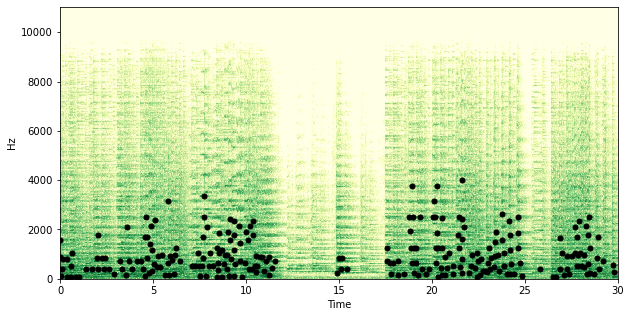

In [150]:
# visualise a constellation map

path = 'database_recordings/classical.00005.wav'

spectr = get_spectr(path)
c_map = constellation_map(spectr, peak_thresh=5)
graph(spectr, c_map)

print(np.max(c_map))

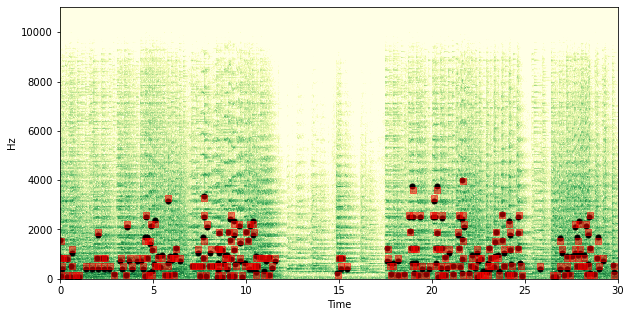

In [151]:
# check that peak picking is selection the correct points

hashmap = hash_map(c_map, freq_bins=32)

graph(spectr, c_map, h_map=hashmap)

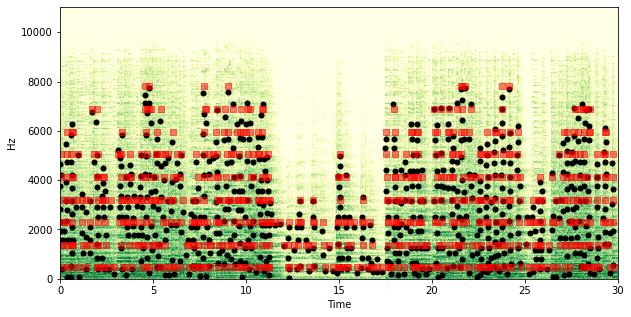

In [152]:
# check the affect of different peak thresholds

path = 'database_recordings/classical.00005.wav'

spectr = get_spectr(path)
c_map = constellation_map(spectr, peak_thresh=0.3, freq_win=30, time_win=12)

hashmap = hash_map(c_map, freq_bins=12)

graph(spectr, c_map, h_map=hashmap)

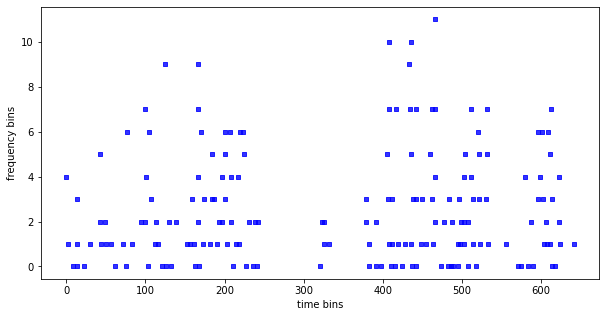

In [162]:
# graph a hash map

graph(h_map=hashmap)

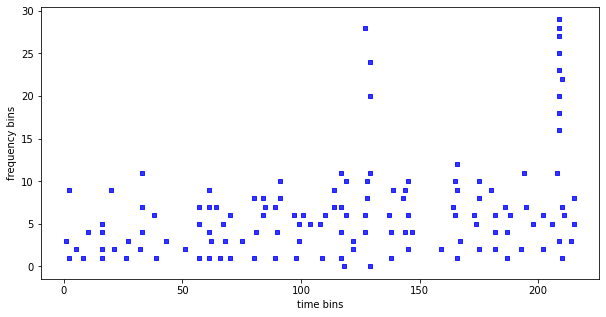

In [392]:
query_path = './query_recordings/classical.00005-snippet-10-0.wav'

spectr = get_spectr(query_path)
c_map = constellation_map(spectr, peak_thresh=1, freq_win=30, time_win=12)

hashmap = hash_map(c_map)

graph(h_map=hashmap)

In [397]:
# check matching function with dummy data

database_hash_fake = [[1, 1, 0, 1, 0, 1, 0], 
                      [0, 0, 1, 0, 1, 0, 0], 
                      [1, 0, 0, 1, 0, 1, 0],
                      [0, 0, 0, 1, 1, 0, 0]]

query_hash_fake = [[0, 0, 0], 
                   [1, 0, 1], 
                   [0, 1, 0], 
                   [0, 1, 1]]

database_list = inverted_list(np.array(database_hash_fake))
query_list = inverted_list(np.array(query_hash_fake))

print(database_list)
print(query_list)

{0: array([0, 1, 3, 5], dtype=int64), 1: array([2, 4], dtype=int64), 2: array([0, 3, 5], dtype=int64), 3: array([3, 4], dtype=int64)}
{1: array([0, 2], dtype=int64), 2: array([1], dtype=int64), 3: array([1, 2], dtype=int64)}


In [398]:
matching_function = matching(query_list, database_list)
print(matching_function)

{2: 5, 4: 2, 0: 1, -1: 1, 3: 1, 1: 1}


In [399]:
weight = match_weight(matching_function)
print(weight)

5


## Perform Parameter Searching

In [ ]:
# set flag for running evaluations
evaluate = False

In [116]:
# first run
if evaluate:
    # create searcher instance
    searcher1 = ParameterRandomSearcher('searcher1_', seed=32)

    # perform first search
    searcher1.get_scores()

    # searcher1.save_obj()

Spectrogram: {'spec_type': 'mel', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 21, 'time_win': 5, 'peak_thresh': 3}
Hash map: {'time_hop': 3, 'freq_bins': 32}
Query threshold multiplier: 0.6
Creating database searcher1_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for file 19

In [121]:
# try some other cominations
if evaluate:
    searcher2 = ParameterRandomSearcher('searcher2_', seed=1)

    for i in range(5):
        searcher2.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 512, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 18, 'time_win': 6, 'peak_thresh': 0.3}
Hash map: {'time_hop': 1, 'freq_bins': 24}
Query threshold multiplier: 0.8
Creating database searcher2_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for file 

evaluating for file 105 out of 106 

Mean accuracy score: 0.5283018867924528
mean roc_auc score: 0.7603109889067979
MAP score: None
best mean accuracy: 0.5849056603773585
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 12, 'time_win': 17, 'peak_thresh': 10}
Hash map: {'time_hop': 3, 'freq_bins': 40}
Query threshold multiplier: 1
Creating database searcher2_2 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 ou

evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.07547169811320754
mean roc_auc score: 0.5214753010334692
MAP score: None
best mean accuracy: 0.5849056603773585
Spectrogram: {'spec_type': 'mel', 'win_len': 512, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 23, 'time_win': 4, 'peak_thresh': 3}
Hash map: {'time_hop': 2, 'freq_bins': 32}
Query threshold multiplier: 0.6
Creating database searcher2_4 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10

In [122]:
# choose smaller range for peak_thresh
if evaluate:
    searcher3 = ParameterRandomSearcher('searcher3_', seed=2, peak_thresh=[0.1, 0.2, 0.3, 0.4])

    for i in range(7):
        searcher3.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 22, 'time_win': 19, 'peak_thresh': 0.4}
Hash map: {'time_hop': 5, 'freq_bins': 32}
Query threshold multiplier: 0.6
Creating database searcher3_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for fil

evaluating for file 105 out of 106 

Mean accuracy score: 0.5471698113207547
mean roc_auc score: 0.728358775007111
MAP score: None
best mean accuracy: 0.5471698113207547
Spectrogram: {'spec_type': 'mel', 'win_len': 512, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 12, 'time_win': 9, 'peak_thresh': 0.1}
Hash map: {'time_hop': 3, 'freq_bins': 32}
Query threshold multiplier: 1
Creating database searcher3_2 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out o

evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.27358490566037735
mean roc_auc score: 0.6430975632881385
MAP score: None
best mean accuracy: 0.5471698113207547
Spectrogram: {'spec_type': 'mel', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 16, 'time_win': 6, 'peak_thresh': 0.1}
Hash map: {'time_hop': 2, 'freq_bins': 40}
Query threshold multiplier: 0.8
Creating database searcher3_4 ...


KeyboardInterrupt: 

In [123]:
# hone in on some time parameters
if evaluate:
    searcher4 = ParameterRandomSearcher('searcher4_', seed=4, peak_thresh=[0.3, 0.5, 0.7], 
                                        time_win=[4, 8, 12], time_hop=[1, 2, 4], 
                                        freq_bins=[32], freq_win=[32])

    for i in range(5):
        searcher4.get_scores()


Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 21, 'time_win': 4, 'peak_thresh': 0.7}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 0.6
Creating database searcher4_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for file

evaluating for file 105 out of 106 

Mean accuracy score: 0.6320754716981132
mean roc_auc score: 0.7607850573622833
MAP score: None
best mean accuracy: 0.6320754716981132
Spectrogram: {'spec_type': 'stft', 'win_len': 512, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 9, 'time_win': 4, 'peak_thresh': 0.7}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 1.4
Creating database searcher4_2 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 ou

KeyboardInterrupt: 

In [124]:
# focus on query_peak_thresh_multiplier effect
if evaluate:
    searcher5 = ParameterRandomSearcher('searcher5_', seed=5, peak_thresh=[0.5], 
                                        time_win=[4, 12], time_hop=[1, 3], 
                                        freq_bins=[32], freq_win=[32, 33], spectr_type=['stft'], 
                                        query_peak_thresh_multiplier=[0.5, 1.0, 1.5], win_len=[1024], 
                                        hop_len=[512])

    for i in range(5):
        searcher5.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 10, 'peak_thresh': 0.5}
Hash map: {'time_hop': 2, 'freq_bins': 32}
Query threshold multiplier: 1.0
Creating database searcher5_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for fil

evaluating for file 105 out of 106 

Mean accuracy score: 0.6886792452830188
mean roc_auc score: 0.7972172181663031
MAP score: None
best mean accuracy: 0.6886792452830188
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 9, 'peak_thresh': 0.5}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 1.0
Creating database searcher5_2 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 

evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.6509433962264151
mean roc_auc score: 0.7837773774533042
MAP score: None
best mean accuracy: 0.6886792452830188
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 11, 'peak_thresh': 0.5}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 0.5
Creating database searcher5_4 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for fil

In [125]:
# narrow search for a wider range of parameters
# try a short stft hop
if evaluate:
    searcher6 = ParameterRandomSearcher('searcher6_', seed=6, peak_thresh=[0.4, 0.5, 0.6], 
                                        time_win=[8, 32], time_hop=[1, 2], 
                                        freq_bins=[24, 32, 40], freq_win=[32, 33], spectr_type=['stft'], 
                                        query_peak_thresh_multiplier=[0.75, 1.0, 1.25, 1.5, 1.75], 
                                        win_len=[1024], hop_len=[256, 512])

    for i in range(10):
        searcher6.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 17, 'peak_thresh': 0.4}
Hash map: {'time_hop': 1, 'freq_bins': 40}
Query threshold multiplier: 1.75
Creating database searcher6_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for fi

evaluating for file 105 out of 106 

Mean accuracy score: 0.6226415094339622
mean roc_auc score: 0.7756945102872855
MAP score: None
best mean accuracy: 0.6792452830188679
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 22, 'peak_thresh': 0.6}
Hash map: {'time_hop': 1, 'freq_bins': 40}
Query threshold multiplier: 0.75
Creating database searcher6_2 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 1

evaluating for file 100 out of 106 
evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.6792452830188679
mean roc_auc score: 0.8256850289181757
MAP score: None
best mean accuracy: 0.6792452830188679
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 30, 'peak_thresh': 0.4}
Hash map: {'time_hop': 1, 'freq_bins': 40}
Query threshold multiplier: 1.5
Creating database searcher6_4 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for f

evaluating for file 95 out of 106 
evaluating for file 96 out of 106 
evaluating for file 97 out of 106 
evaluating for file 98 out of 106 
evaluating for file 99 out of 106 
evaluating for file 100 out of 106 
evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.6226415094339622
mean roc_auc score: 0.7969327770930124
MAP score: None
best mean accuracy: 0.6792452830188679
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 512}
Constellation map: {'hop_length': 512, 'freq_win': 32, 'time_win': 28, 'peak_thresh': 0.5}
Hash map: {'time_hop': 1, 'freq_bins': 24}
Query threshold multiplier: 1.25
Creating database searcher6_6 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating

evaluating for file 90 out of 106 
evaluating for file 91 out of 106 
evaluating for file 92 out of 106 
evaluating for file 93 out of 106 
evaluating for file 94 out of 106 
evaluating for file 95 out of 106 
evaluating for file 96 out of 106 
evaluating for file 97 out of 106 
evaluating for file 98 out of 106 
evaluating for file 99 out of 106 
evaluating for file 100 out of 106 
evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.6792452830188679
mean roc_auc score: 0.8257798426092726
MAP score: None
best mean accuracy: 0.6792452830188679
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 256}
Constellation map: {'hop_length': 256, 'freq_win': 32, 'time_win': 8, 'peak_thresh': 0.4}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 1.0
Creating database searcher6_8 ...
199 files created out of 200 ...

evaluating for file 85 out of 106 
evaluating for file 86 out of 106 
evaluating for file 87 out of 106 
evaluating for file 88 out of 106 
evaluating for file 89 out of 106 
evaluating for file 90 out of 106 
evaluating for file 91 out of 106 
evaluating for file 92 out of 106 
evaluating for file 93 out of 106 
evaluating for file 94 out of 106 
evaluating for file 95 out of 106 
evaluating for file 96 out of 106 
evaluating for file 97 out of 106 
evaluating for file 98 out of 106 
evaluating for file 99 out of 106 
evaluating for file 100 out of 106 
evaluating for file 101 out of 106 
evaluating for file 102 out of 106 
evaluating for file 103 out of 106 
evaluating for file 104 out of 106 
evaluating for file 105 out of 106 

Mean accuracy score: 0.6320754716981132
mean roc_auc score: 0.7953209443443632
MAP score: None
best mean accuracy: 0.7075471698113207


In [153]:
if evaluate:
    searcher7 = ParameterRandomSearcher('searcher7_', seed=7, peak_thresh=[0.35, 0.4, 0.45], 
                                        time_win=[4, 9], time_hop=[1, 3], 
                                        freq_bins=[32], freq_win=[32, 33], spectr_type=['stft'], 
                                        query_peak_thresh_multiplier=[1.0], 
                                        win_len=[1024], hop_len=[128, 256])

    for i in range(6):
        searcher7.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 128}
Constellation map: {'hop_length': 128, 'freq_win': 32, 'time_win': 8, 'peak_thresh': 0.4}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 1.0
Creating database searcher7_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for file

evaluating for file 105 out of 106 

Mean accuracy score: 0.6132075471698113
mean roc_auc score: 0.7649094529250025
MAP score: None
best mean accuracy: 0.660377358490566
Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 128}
Constellation map: {'hop_length': 128, 'freq_win': 32, 'time_win': 6, 'peak_thresh': 0.35}
Hash map: {'time_hop': 2, 'freq_bins': 32}
Query threshold multiplier: 1.0
Creating database searcher7_2 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 

KeyboardInterrupt: 

In [154]:
if evaluate:
    searcher8 = ParameterRandomSearcher('searcher8_', seed=8, peak_thresh=[0.2], 
                                        time_win=[8, 9], time_hop=[1, 3], 
                                        freq_bins=[32], freq_win=[32, 33], spectr_type=['stft'], 
                                        query_peak_thresh_multiplier=[2.0], 
                                        win_len=[1024], hop_len=[256])

    for i in range(1):
        searcher8.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 256}
Constellation map: {'hop_length': 256, 'freq_win': 32, 'time_win': 8, 'peak_thresh': 0.2}
Hash map: {'time_hop': 2, 'freq_bins': 32}
Query threshold multiplier: 2.0
Creating database searcher8_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for file

In [164]:
# test best parameters
print(searcher6.best_scores)
print(searcher6.search_params[8]['params'])

{0.6792452830188679: 7, 0.6226415094339622: 5, 0.6509433962264151: 6, 0.6698113207547169: 4, 0.7075471698113207: 8, 0.6320754716981132: 9}
({'spec_type': 'stft', 'win_len': 1024, 'hop_len': 256}, {'hop_length': 256, 'freq_win': 32, 'time_win': 8, 'peak_thresh': 0.4}, {'time_hop': 1, 'freq_bins': 32})


In [177]:
if evaluate:
    searcher9 = ParameterRandomSearcher('searcher9_', seed=9, peak_thresh=[0.4], 
                                        time_win=[8, 9], time_hop=[1, 2], 
                                        freq_bins=[32], freq_win=[32, 33], spectr_type=['stft'], 
                                        query_peak_thresh_multiplier=[1.0], 
                                        win_len=[1024], hop_len=[256])

    for i in range(1):
        searcher9.get_scores()

Spectrogram: {'spec_type': 'stft', 'win_len': 1024, 'hop_len': 256}
Constellation map: {'hop_length': 256, 'freq_win': 32, 'time_win': 8, 'peak_thresh': 0.4}
Hash map: {'time_hop': 1, 'freq_bins': 32}
Query threshold multiplier: 1.0
Creating database searcher9_0 ...
199 files created out of 200 ...
performing evaluation ...
evaluating for file 0 out of 106 
evaluating for file 1 out of 106 
evaluating for file 2 out of 106 
evaluating for file 3 out of 106 
evaluating for file 4 out of 106 
evaluating for file 5 out of 106 
evaluating for file 6 out of 106 
evaluating for file 7 out of 106 
evaluating for file 8 out of 106 
evaluating for file 9 out of 106 
evaluating for file 10 out of 106 
evaluating for file 11 out of 106 
evaluating for file 12 out of 106 
evaluating for file 13 out of 106 
evaluating for file 14 out of 106 
evaluating for file 15 out of 106 
evaluating for file 16 out of 106 
evaluating for file 17 out of 106 
evaluating for file 18 out of 106 
evaluating for file

In [204]:
if evaluate:
    searcher9.test(0)

performing evaluation ...
evaluating for file 106 out of 107 
Mean ROC_AUC score: 0.7763819095477386, mean accuracy score: 0.6355140186915887


# Final functions - Please use these for testing

In [201]:
def fingerprintBuilder(database_path, 
                       fingerprints_path):
    """
    Final test function for building fingerprint database
    """
    file_list = os.listdir(database_path)
    total_files = len(file_list)
    
    # loop through files
    for i, audiofile in enumerate(file_list):
        
        print(f"{i} files created out of {total_files} ...", end='\r')
        
        audiofilepath = os.path.join(database_path, audiofile)
        
        # get inverted list
        out = get_inverted_list(audiofilepath)
        
        # get filename in correct format        
        name = os.path.splitext(os.path.split(audiofile)[1])[0]        
        name = name + '.pkl'        
        name = os.path.join(fingerprints_path, name)
        
        # save list
        with open(name, 'wb') as f:
            pickle.dump(out, f)
        
    print('')
    

In [210]:
def audioIdentification(queryset_path, fingerprints_path, output_path):
    """
    Final test function for outputting .txt file with top-3 matches
    """
    # text file name
    output_name = 'output.txt'
    output_name = os.path.join(output_path, output_name)
    
    # open output file
    with open(output_name, 'w') as txt_file:
    
        # loop through query items    
        for query_file in os.listdir(queryset_path):
            
            # get full path
            queryfile = os.path.join(queryset_path, query_file)

            # get inverted list
            out = get_inverted_list(queryfile)

            # get list of best matches
            query_matches, _, _ = best_matches_list(out, fingerprints_path, num_outputs=3, 
                                                    query_name=None)
            
            print(query_matches)
            
            
            # get list of file names
            output_files = []
            for weight, name in sorted(query_matches):
                output_files.append(name)

            print(query_file)
            print(f"{query_file}\t{output_files[2]}\t" \
                           f"{output_files[1]}\t{output_files[0]}\n")
                
            # write to file
            txt_file.write(f"{query_file}\t{output_files[2]}\t" \
                           f"{output_files[1]}\t{output_files[0]}\n")
            
        print(f"file {output_name} created")
  